In [56]:
import ipywidgets
import numpy as np
import pandas as pd

from imblearn.ensemble import BalancedRandomForestClassifier
from IPython.display import display, clear_output
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [20]:
cepi = pd.read_csv('C Elegans dataset examples\Version-1 datasets (no score threshold)\CElegans Protein Interactors dataset_v1.tsv', sep='\t')
dmpi = pd.read_csv('Drosophila datasets (validation experiment)/Drosophila Protein Interactors .tsv', sep='\t')
cego = pd.read_csv('C Elegans dataset examples\Version-1 datasets (no score threshold)\CElegans GOTerms dataset_v1.tsv', sep='\t')
dmgo = pd.read_csv('Drosophila datasets (validation experiment)\Drosophila GO Terms.tsv', sep='\t')

In [21]:
drop_cols = [
    'Instance_Index',
    'STITCH_Code',
    'STITCH_Compound',
    'STITCH Code',
    'InteractorsList',
    'InteractorsCount'
]
cepi.drop(columns=drop_cols, errors='ignore',inplace=True)
dmpi.drop(columns=drop_cols, errors='ignore',inplace=True)
cego.drop(columns=drop_cols, errors='ignore',inplace=True)
dmgo.drop(columns=drop_cols, errors='ignore',inplace=True)

(cepi.shape, dmpi.shape, cego.shape, dmgo.shape)

((1120, 5789), (45, 5789), (1120, 9001), (45, 9001))

In [62]:
def permute(row: np.array):
    n_row = row.shape[1]
    X = np.tile(row, n_row).reshape(n_row,n_row)
    mask = np.identity(n_row, dtype=int)
    return X^ mask

In [36]:
def predict_proba(df: pd.DataFrame, left_out: int, balanced=False):
    all_rows = np.arange(df.shape[0])
    rows = np.delete(all_rows, left_out)
    X = df.iloc[rows,:-1].values
    y = df.iloc[rows,-1].values
    if balanced:
        model = BalancedRandomForestClassifier(n_estimators=100, n_jobs=-1, sampling_strategy='auto', replacement=False, random_state=0)
    else:
        model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
    model.fit(X, y)
    left_row = df.iloc[left_out,:-1].values.reshape(1,-1)
    proba = model.predict_proba(left_row)[0][1]
    permuted_y = model.predict_proba(permute(left_row))
    return proba, model.feature_importances_, permuted_y[:,1]

Seja o conjunto de dados $\mathfrak{D} = \left \{ \langle X^{[i]}, y^{[i]} \rangle , i = (1,2,3, \dots ,n) \right \} $, Onde $i$ representa a $i$-ésima característica
$$

\bold{X} = 

\begin{bmatrix}
x_{1}^{[1]}   & \cdots & x_{j-1}^{[1]}   & x_{j}^{[1]}   & x_{j+1}^{[1]}   & \cdots & x_{m}^{[1]}\\
x_{1}^{[2]}   & \cdots & x_{j-1}^{[2]}   & x_{j}^{[2]}   & x_{j+1}^{[2]}   & \cdots & x_{m}^{[2]}\\
\vdots        & \ddots & \vdots          & \vdots        & \vdots        & \ddots & \vdots     \\
x_{1}^{[i-1]}   & \cdots & x_{j-1}^{[i-1]}   & x_{j}^{[i-1]}   & x_{j+1}^{[i-1]}   & \cdots & x_{m}^{[i-1]}\\
x_{1}^{[i]}   & \cdots & x_{j-1}^{[i]}   & x_{j}^{[i]}   & x_{j+1}^{[i]}   & \cdots & x_{m}^{[i]}\\
x_{1}^{[i+1]}   & \cdots & x_{j-1}^{[i+1]}   & x_{j}^{[i+1]}   & x_{j+1}^{[i+1]}   & \cdots & x_{m}^{[i+1]}\\
\vdots        & \ddots & \vdots          & \vdots        & \vdots        & \ddots & \vdots     \\
x_{1}^{[n-1]} & \cdots & x_{j-1}^{[n-1]} & x_{j}^{[n-1]} & x_{j+1}^{[n-1]} & \cdots & x_{m}^{[n-1]}\\
x_{1}^{[n]}   & \cdots & x_{j-1}^{[n]}   & x_{j}^{[n]}   & x_{j+1}^{[n]}   & \cdots & x_{m}^{[n]}\\
\end{bmatrix}

$$


In [77]:
proba = np.array([])
permuted_y = np.array([])
gvim = np.array([])
pvim = np.array([])

n = cepi.shape[0]
m = cepi.shape[1]-1
y = cepi.iloc[:,-1].values

w = ipywidgets.IntProgress(min=0,max=n)
display(w)

for i in range(n):
    proba_, gvim_, permuted_y_ = predict_proba(df=cepi, left_out=i, balanced=False)
    proba = np.append(proba, proba_)
    gvim = np.append(gvim, gvim_)
    permuted_y = np.append(permuted_y, permuted_y_)
    w.value = i
    
auc_baseline = roc_auc_score(y, proba)

permuted_y = permuted_y.reshape(n,m)

for j in range(m):
    auc_feature = roc_auc_score(y, permuted_y[:,j])
    pvim = np.append(pvim, auc_baseline-auc_feature)

print(f"AUC baseline: {auc_baseline:.03f}")

IntProgress(value=0, max=1120)

AUC baseline: 0.728


Axes(0.125,0.11;0.775x0.77)


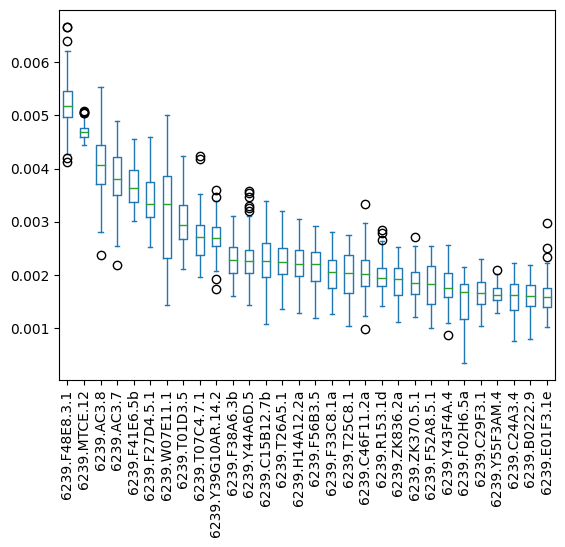

In [93]:
fi = pd.DataFrame(feature_importances, columns=cepi.columns[:-1])
index = np.argsort(fi.median())[::-1]
print(fi.iloc[:,index.values[0:30]].plot.box(rot=90))

Axes(0.125,0.11;0.775x0.77)


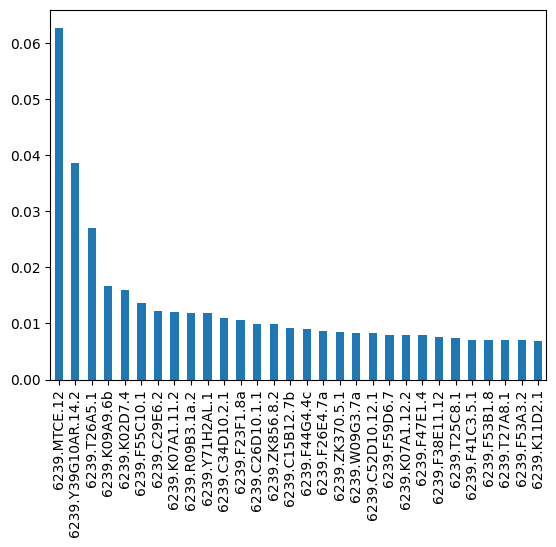

In [94]:
index_p = np.argsort(pvim)[::-1]
print(pd.Series(pvim, index=cepi.columns[:-1])[index_p[0:30]].plot.bar())

In [99]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold

k = 10
sk_pvim = np.array([])
w = ipywidgets.IntProgress(min=0,max=k)
display(w)

X = cepi.iloc[:,:-1].values
y = cepi.iloc[:,-1].values

kfold = StratifiedKFold(n_splits=k)

model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)

for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
    
    w.value = i
    
    model.fit(X[train_index], y[train_index])
    
    fold_pvim = permutation_importance(model, X, y, scoring='roc_auc', n_repeats=5, n_jobs=-1)
    
    sk_pvim = np.append(sk_pvim, fold_pvim.importances)
    

IntProgress(value=0, max=10)

KeyboardInterrupt: 

In [101]:
test_index

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  49,  51,  53,  54,  57,
        58,  62,  64,  66,  69,  71,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132])

In [103]:
fold_pvim = permutation_importance(model, X, y, scoring='roc_auc', n_repeats=4, n_jobs=-1)

In [104]:
fold_pvim

{'importances_mean': array([0.00000000e+00, 3.10005425e-04, 5.92657430e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'importances_std': array([0., 0., 0., ..., 0., 0., 0.]),
 'importances': array([[0.00000000e+00],
        [3.10005425e-04],
        [5.92657430e-05],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]])}